# Setup

In [1]:
#!/usr/bin/env python3
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.style.use(["science", "nature", "notebook"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer", "Noto Serif CJK jp"],
        "font.size": 11,
        "text.usetex": False,
        "mathtext.fontset": "stixsans",
        "figure.figsize": (5, 3),
    }
)

from prep import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import seaborn as sns
import functools
from stargazer.stargazer import Stargazer

df = pd.read_csv("../data/viz_learn_preds.csv", index_col=0)


def linear_model(formula, df, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    if model_name is None:
        model_name = formula.format(targ)
    fig, annot = plot_regression_once(preds, targs, model_name)
    return results, fig


@functools.lru_cache
def lm(formula, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    return results


def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [2]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["method"] = set_base(df["method"], "歩")
df["apt_style"] = df["apt_style"].apply(apt_style_clean)
df["time_to_station_sq"] = df["time_to_station"] ** 2
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")
# df = df[df["valid"]]

In [3]:
corr = df[["log_apt_rent","viz_preds", "b_age", "apt_size", "b_no_floors", "apt_floor", "apt_admin_price", "time_to_station"]].corr()
names = {
    "apt_size": r"Apt Size($ m^2 $)",
    "b_no_floors": "B. No. Floors",
    "b_age": "B. Age",
    "apt_floor": "Apt Floor",
    "apt_admin_price": "Admin Fee",
    "time_to_station" : "T. t. station",
    "viz_preds": 'NN factor',
    "log_apt_rent": "log(rent)"
}
corr = corr.rename(names, axis=1).rename(names, axis=0)

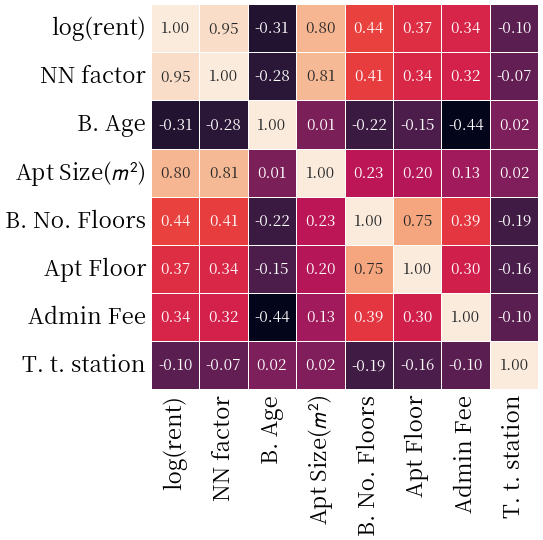

In [4]:
mpl.rc('text', usetex = False)

plt.figure(figsize=(5, 5))
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False, right=False
    ) 

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidths=0.5, cbar=False,fmt=".2f", annot_kws={"fontsize": "11"} )
plt.savefig("../../paper/assets/corrplot.png",bbox_inches="tight", dpi=300,transparent=False)

In [5]:
mod1 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style",
    # "+ viz_preds",
    "log_apt_rent",
    model_name="Without NN",
)
mod2 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style"
    "+ viz_preds",
    "log_apt_rent",
    model_name="With NN",
)

mod3 = lm(
    "{} ~ viz_preds", 
    "log_apt_rent",
    model_name="Only NN"
)
df["mod1preds"] = mod1.predict(df)
df["mod2preds"] = mod2.predict(df)
df["exp_mod1preds"] = np.exp(df["mod1preds"])
df["exp_mod2preds"] = np.exp(df["mod2preds"])

In [6]:
sg = Stargazer([mod1, mod2, mod3])

# Stargazer

In [7]:
from stargazer.stargazer import Stargazer, LineLocation
def latex_format(name, cap):
    template = "\n\caption{{\label{{{}}}{}}}\n"
    return template.format(name, cap)
    
        
sg = Stargazer([mod1, mod2, mod3])
def de_free(mod):
    return sg.extract_model_data(mod)["degree_freedom"]

styles = list(filter(lambda x: x.startswith("apt_style"), sg.cov_names))

order = [
    "Intercept",
    "apt_size",
    "b_age",
    "b_no_floors",
    "apt_floor",
    "apt_admin_price",
    "time_to_station",
    "time_to_station_sq",
    "viz_preds"
] #+ styles

sg.covariate_order(order)

sg.rename_covariates({
    "apt_size": "Apartment Size(\(m^2\))",
    "b_no_floors": "No. Floors(Building)",
    "b_age": "Building age",
    "apt_floor": "Apartment Floor",
    "apt_admin_price": "Administration Price",
    "time_to_station" : "Time to station",
    "time_to_station_sq": "Time to station\(^2\)",
    "viz_preds": 'NN Factor',
})
sg.add_line('Degrees of Freedom', [de_free(mod1), de_free(mod2), de_free(mod3)], LineLocation.FOOTER_TOP)
sg.custom_columns(['1) Without NN', '2) With NN', "3) Only NN"], [1, 1, 1])
sg.show_model_numbers(False)
sg.add_custom_notes([''])
sg.dependent_variable_name("Dependent variable: \( log(apt\_rent) \)")
sg.show_degrees_of_freedom(False)
sg.dependent_variable = ""

In [8]:
valid_df = df[df["valid"]]
valid_df[["apt_rent", "exp_mod1preds", "exp_mod2preds"]]

,apt_rent,exp_mod1preds,exp_mod2preds
0,7.70,8.925976,8.150487
7,8.57,9.038041,8.567440
9,8.62,9.132446,9.127560
10,7.70,8.925976,8.281410
14,8.22,8.816326,8.291097
...,...,...,...
141376,22.60,20.912606,24.762719
141380,7.00,7.894393,7.459304
141388,10.70,9.786129,10.275196
141391,6.20,6.782396,6.845031


In [9]:
valid_df.shape

(28278, 28)

In [12]:
df[df["apt_rent"] < 60].shape, df.shape
def rmse(a, b):
    a = a*10_000
    b = b*10_000
    res = a - b 
    return np.sqrt((res**2).mean())

In [13]:
print("Complete Validation: ")
print("N:                 ",  len(valid_df))
print("RMSE Baseline      ",  rmse(valid_df["exp_mod1preds"], valid_df["apt_rent"]))
print("RMSE w/ floorplans ",  rmse(valid_df["exp_mod2preds"], valid_df["apt_rent"]))

print()
other_val_df = valid_df[valid_df["apt_rent"] < 100]
print("Validation (100万以下の物件のみ）: ")
print("N:                 ",  len(other_val_df))
print("RMSE Baseline      ",  rmse(other_val_df["exp_mod1preds"], other_val_df["apt_rent"]))
print("RMSE w/ floorplans ",  rmse(other_val_df["exp_mod2preds"], other_val_df["apt_rent"]))

print()
other_val_df = valid_df[valid_df["apt_rent"] < 60]
print("Validation (60万以下の物件のみ）: ")
print("N:                 ",  len(other_val_df))
print("RMSE Baseline      ",  rmse(other_val_df["exp_mod1preds"], other_val_df["apt_rent"]))
print("RMSE w/ floorplans ",  rmse(other_val_df["exp_mod2preds"], other_val_df["apt_rent"]))

Complete Validation: 
N:                  28278
RMSE Baseline       550203.7082306442
RMSE w/ floorplans  86618.46975316452

Validation (100万以下の物件のみ）: 
N:                  28248
RMSE Baseline       25779.194548225987
RMSE w/ floorplans  22491.584593007174

Validation (60万以下の物件のみ）: 
N:                  28170
RMSE Baseline       19035.127509802303
RMSE w/ floorplans  17147.53675087221


In [14]:
other_val_df = valid_df[valid_df["apt_rent"] < 100]
print(other_val_df.shape, valid_df.shape)
print(rmse(other_val_df["exp_mod1preds"], other_val_df["apt_rent"]))
print(rmse(other_val_df["exp_mod2preds"], other_val_df["apt_rent"]))

(28248, 28) (28278, 28)
25779.194548225987
22491.584593007174


In [15]:
rmse(other_val_df["exp_mod1preds"], other_val_df["apt_rent"])

25779.194548225987

In [16]:
sg

In [17]:
tab_file="../../paper/assets/table2.tex" 
with open(tab_file, "w") as f:
    f.write(sg.render_latex())

In [18]:
from fastai.vision.all import *

/home/jjs/.cache/pypoetry/virtualenvs/real-estate-analysis-K1XLhMhm-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
create_head??

Signature:
create_head(
    nf,
    n_out,
    lin_ftrs=None,
    ps=0.5,
    pool=True,
    concat_pool=True,
    first_bn=True,
    bn_final=False,
    lin_first=False,
    y_range=None,
)
Source:   
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, pool=True, concat_pool=True, first_bn=True, bn_final=False,
                lin_first=False, y_range=None):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    if pool and concat_pool: nf *= 2
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    bns = [first_bn] + [True]*len(lin_ftrs[1:])
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if pool:
        pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        layers += [pool, Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,bn,p,actn in zip(lin_f

In [20]:
# \caption{\label{tab:var_explanation}An explanation of the variables that were collected and used in this study.}
cap = """Esimated coefficients (Standard Erorrs) for the variables in Table \\ref{tab:var_explanation}.
These coefficients were estimated with the hedonic price model explained. However, because of the high cardinality 
of the categorical variables of Apartment style and closest station, we excluded the two variables here.%
"""
name = "tab:regression"
capstring = latex_format(name, cap) 

def write_label(capstring, tab_file, write=True, resize=False):
    if resize:
        capstring= capstring + "\\resizebox{\columnwidth}{!}{%\n"
    outstring=""
    with open(tab_file, "r") as f:
        outstring = (f" {capstring} ".join(f.readline().split(" ")))
        outstring += f.read()
    if resize:
        outstring = "\end{tabular}%\n}".join(outstring.split(r"\end{tabular}"))
    if write:
        with open(tab_file, "w") as f:
            f.write(outstring)
    else:
        print(outstring)

write_label(capstring, tab_file, write=True)

# Looking at predictions

In [21]:
import os 
from PIL import Image
from pathlib import Path
from IPython.display import Image
from IPython.display import display
import matplotlib.image as mplimg


In [22]:
root =  Path("/Users/jiyanschneider/Dropbox/scraper/imgs/")
def image_path(f, path=root):
    return mplimg.imread(path / f)


In [23]:
df["exp_viz_preds"] = np.exp(df["viz_preds"])
df["exp_viz_targs"] = np.exp(df["viz_targs"])
   

In [24]:
df["station"].unique()

['ＪＲ山手線/浜松町駅', '都営大江戸線/汐留駅', '東京メトロ銀座線/溜池山王駅', '東急池上線/石川台駅', '東京メトロ千代田線/千駄木駅', ..., '都営バス/新小岩駅北口', '国際興業バス/小豆沢２丁目', '千01/千住中居町', '都営大江戸線/練馬春日町駅', '北01/いずみ記念病院前']
Length: 684
Categories (684, object): ['ＪＲ山手線/浜松町駅', '都営大江戸線/汐留駅', '東京メトロ銀座線/溜池山王駅', '東急池上線/石川台駅', ..., '国際興業バス/小豆沢２丁目', '千01/千住中居町', '都営大江戸線/練馬春日町駅', '北01/いずみ記念病院前']

In [25]:
def show_imgs(l, title=None, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, pred, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{pred:.2f}/{actual:.2f}")
    if not title:
        plt.suptitle("Prediction/Actual", fontsize=20)
    else:
        plt.suptitle(title, fontsize=20)
    return fig

def show_pred_imgs(l, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, mod1, mod2, NN, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{mod1:.2f}/{mod2:.2f}/{NN:.2f}/{actual:.2f}")
    plt.suptitle("Model1/Model2/NN/Actual", fontsize=20)
    return fig


def image_triple(idxs, exp=True):
    if exp:
        return list(df[["rel_image_paths", "exp_viz_preds", "exp_viz_targs"]].loc[idxs].to_records(index=False))
    else: 
        return list(df[["rel_image_paths", "viz_preds", "viz_targs"]].loc[idxs].to_records(index=False))

def pred_tup(idxs, cols):
    return list(df[["rel_image_paths", *cols]].loc[idxs].to_records(index=False))
        

def random_images(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    rands = list(np.random.randint(0, len(df), size=N))
    return image_triple(rands)



## Random predictions

In [26]:
random_images(5)

[('full/22f1cfa6c1ac152babb69a061b589f1a47a5b43d.jpg', 9.31674576, 9.0000002),
 ('full/ea0636fd78b9589f94b6209771eb9f18587bf76e.jpg', 5.24049364, 5.00000044),
 ('full/323094a8db48e23ea96e40a2a61f85a0f704c051.jpg', 15.49586168, 17.3000017),
 ('full/6de1f96e84c821c4e867f50e769a9244d91e1a21.jpg', 10.5854096, 8.9000011),
 ('full/f264ac3295ef65afddb119d202253d254ae74386.jpg', 7.29723712, 5.00000044)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/a2a59ac192e980871771950ad1c05b6cdbc1b040.jpg'

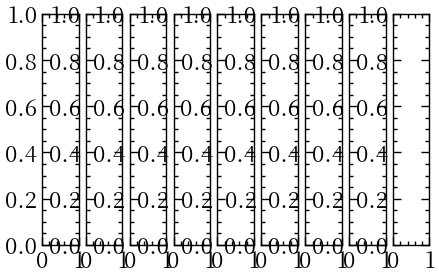

In [27]:
def show_imgs_row(l, title=None, **kwargs):
    no_imgs = len(l)
    n_rows = 1
    n_cols = 9
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, pred, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{pred:.2f}/{actual:.2f}")
    if not title:
        plt.suptitle("Prediction/Actual", fontsize=20)
    else:
        plt.suptitle(title, fontsize=20)
    return fig

show_imgs_row(image_triple(range(1, 10)))


In [28]:
dpi=150

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/fe4310622e17b3e400093ef9739a3d4ac79ab3d0.jpg'

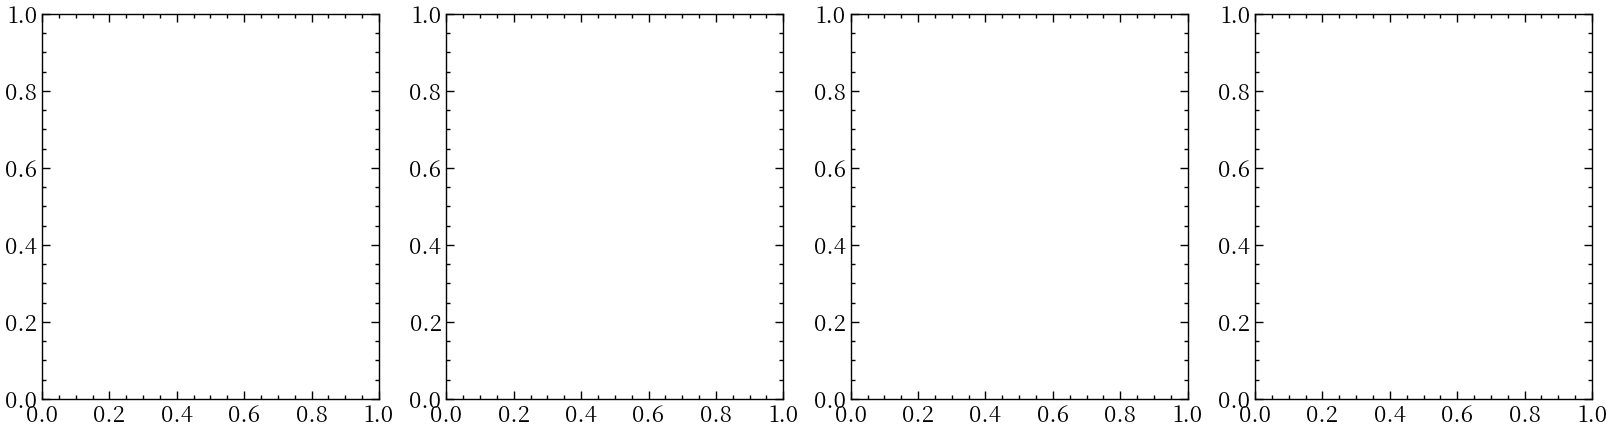

In [29]:
x = show_imgs(random_images(4, seed=2021), figsize=(20, 5))
# x.savefig("../../paper/assets/random_table.png", dpi=dpi)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/198ddaf36081c0463ed7b137bf48370018c8e9a4.jpg'

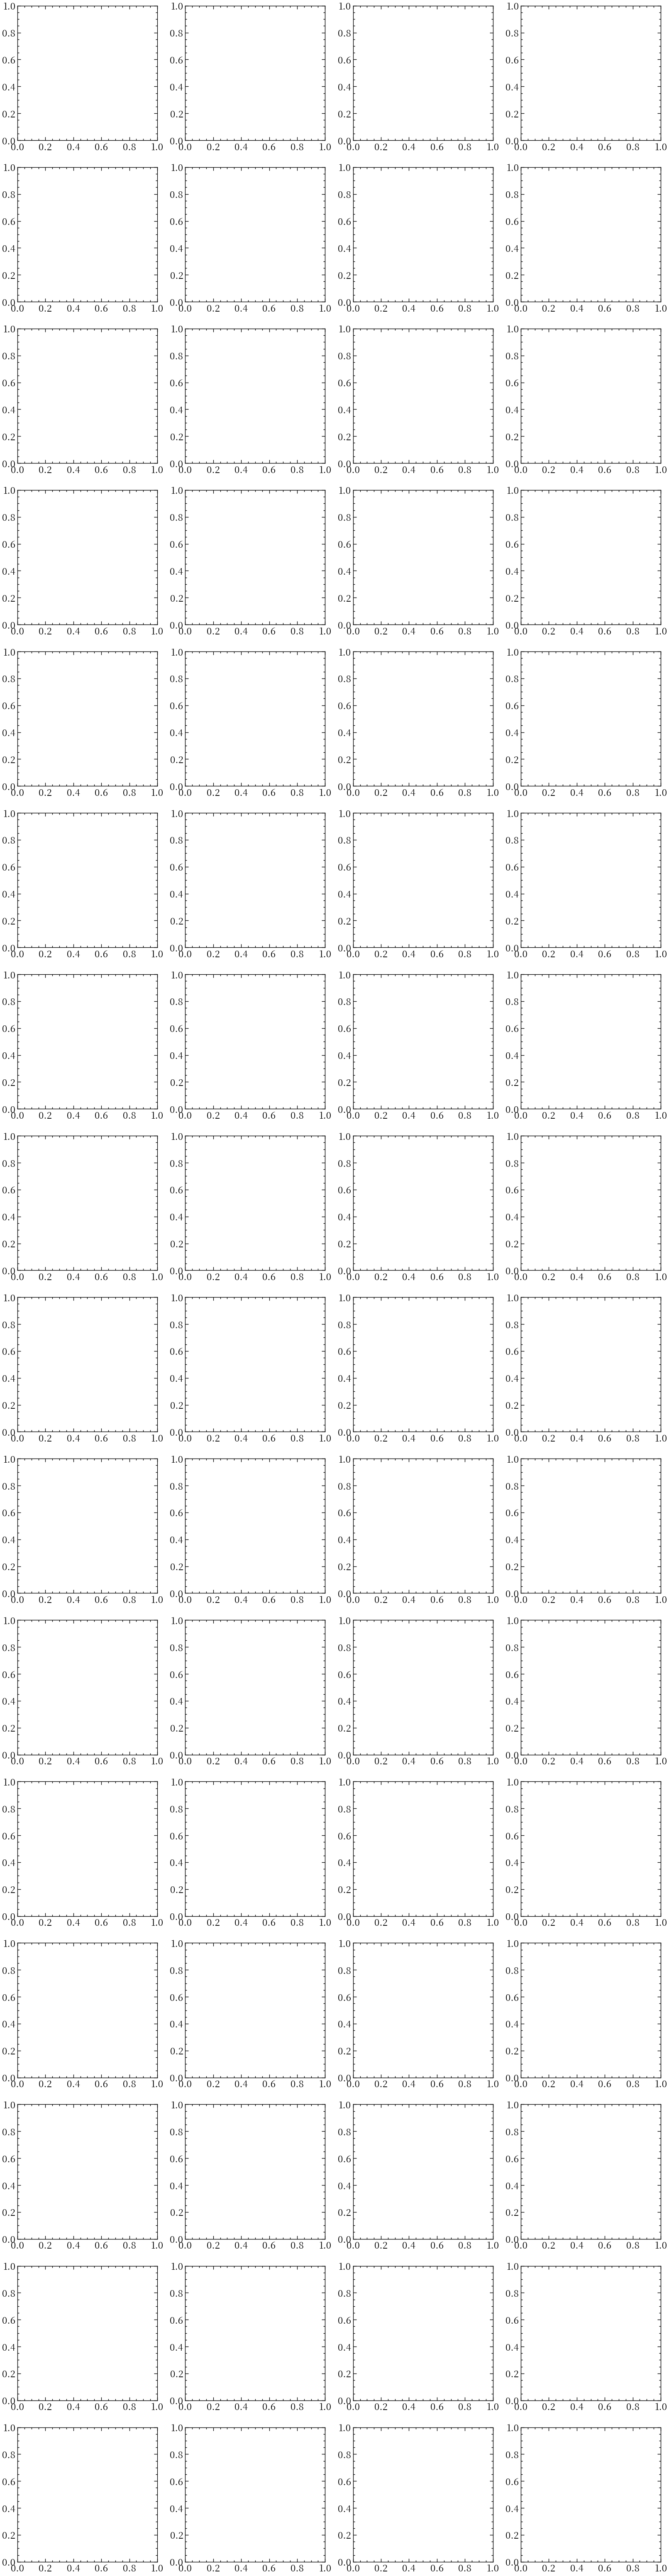

In [30]:
x = show_imgs(random_images(64), figsize=(20, 80))

In [ ]:
from fastcore.all import L

In [ ]:
M = 100
N = 12
highest_idx = L(df.sort_values("viz_preds").index.to_list()[:M])
np.random.seed(41)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(20, 5))
# x.savefig("../../paper/assets/random_negtop100.png", dpi=dpi)

In [32]:
df.sort_values("viz_preds", ascending=False)["full_apt_detail_link"].iloc[:16]

9284      https://suumo.jp//chintai/jnc_000069469936/?bc=100256836682
9283      https://suumo.jp//chintai/jnc_000069771219/?bc=100258491447
83112     https://suumo.jp//chintai/jnc_000047361370/?bc=100148670208
122110    https://suumo.jp//chintai/jnc_000070549042/?bc=100242673267
118301    https://suumo.jp//chintai/jnc_000069857805/?bc=100240898352
9285      https://suumo.jp//chintai/jnc_000069690535/?bc=100257550364
3026      https://suumo.jp//chintai/jnc_000069600375/?bc=100257551077
3027      https://suumo.jp//chintai/jnc_000069181704/?bc=100255309930
61047     https://suumo.jp//chintai/jnc_000070672737/?bc=100263498984
118432    https://suumo.jp//chintai/jnc_000036568352/?bc=100258405821
92205     https://suumo.jp//chintai/jnc_000067639757/?bc=100246641036
120578    https://suumo.jp//chintai/jnc_000069607308/?bc=100258698358
28690     https://suumo.jp//chintai/jnc_000069691144/?bc=100259417749
118430    https://suumo.jp//chintai/jnc_000069817288/?bc=100258405822
44082     https://su

In [33]:
df["full_apt_detail_link"]

0         https://suumo.jp//chintai/jnc_000061132945/?bc=100263201569
1         https://suumo.jp//chintai/jnc_000070609463/?bc=100263210743
2         https://suumo.jp//chintai/jnc_000070526953/?bc=100262776795
3         https://suumo.jp//chintai/jnc_000068981658/?bc=100243194498
4         https://suumo.jp//chintai/jnc_000068805635/?bc=100244617149
                                     ...                             
141389    https://suumo.jp//chintai/jnc_000066036326/?bc=100242715280
141390    https://suumo.jp//chintai/jnc_000066036319/?bc=100242715305
141391    https://suumo.jp//chintai/jnc_000063710214/?bc=100222839495
141392    https://suumo.jp//chintai/jnc_000069954314/?bc=100259475075
141393    https://suumo.jp//chintai/jnc_000070538932/?bc=100206043708
Name: full_apt_detail_link, Length: 141394, dtype: object

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/1dacacc8188e42caa080664279248456e1ee82cb.jpg'

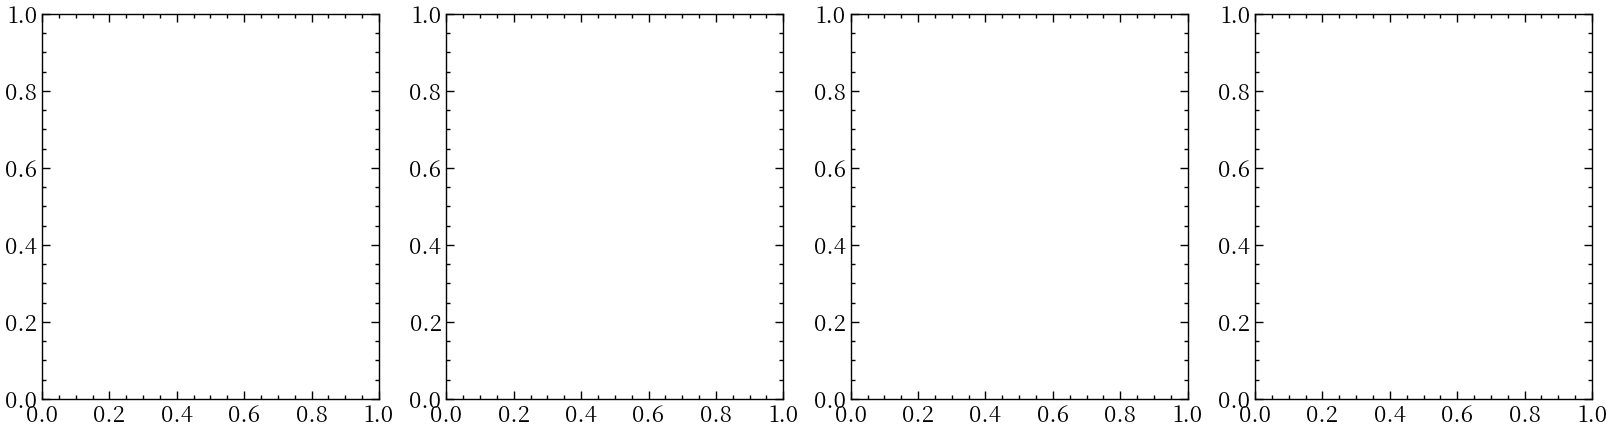

In [34]:
highest_idx = L(df.sort_values("viz_preds", ascending=True).index.to_list()[:4])
np.random.seed(49)
rands = highest_idx[list(range(0, 4))]
x = show_imgs(image_triple(rands), figsize=(20, 5))
# x.savefig("../../paper/assets/rand_neg_top_100.png", dpi=dpi)

In [ ]:
highest_idx = L(df.sort_values("viz_preds", ascending=True).index.to_list()[:5])
# np.random.seed(49)
# rands = highest_idx[list(range(0, 16))]
x = show_imgs(image_triple(rands), figsize=(20, 20))
# x.savefig("../../paper/assets/rand_top_100.png", dpi=dpi)

In [35]:
highest_idx = L(df.sort_values("viz_preds", ascending=False).index.to_list()[:M])
np.random.seed(49)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(20, 5))
# x.savefig("../../paper/assets/rand_top_100.png", dpi=dpi)

NameError: name 'M' is not defined

In [36]:
np.exp(6)

403.4287934927351

In [37]:
mistakes = (df["mod1preds"] - df["mod2preds"]).sort_values()

In [38]:
underestimates = mistakes[:1].index.to_list() + mistakes[9:13].index.to_list()
overestimates = mistakes[-12:-7].index.to_list()

/tmp/ipykernel_14188/1324551120.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  underestimates = mistakes[:1].index.to_list() + mistakes[9:13].index.to_list()
/tmp/ipykernel_14188/1324551120.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  overestimates = mistakes[-12:-7].index.to_list()


In [39]:
mistakes

134559   -1.135887
24995    -1.113866
7888     -0.905808
127358   -0.898539
60747    -0.890635
            ...   
9284      1.381810
102075    1.384596
3027      1.450149
40858     1.478921
125321    1.904160
Length: 141394, dtype: float64

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/efebc5c337d85e5b88bf9590075764da2b974039.jpg'

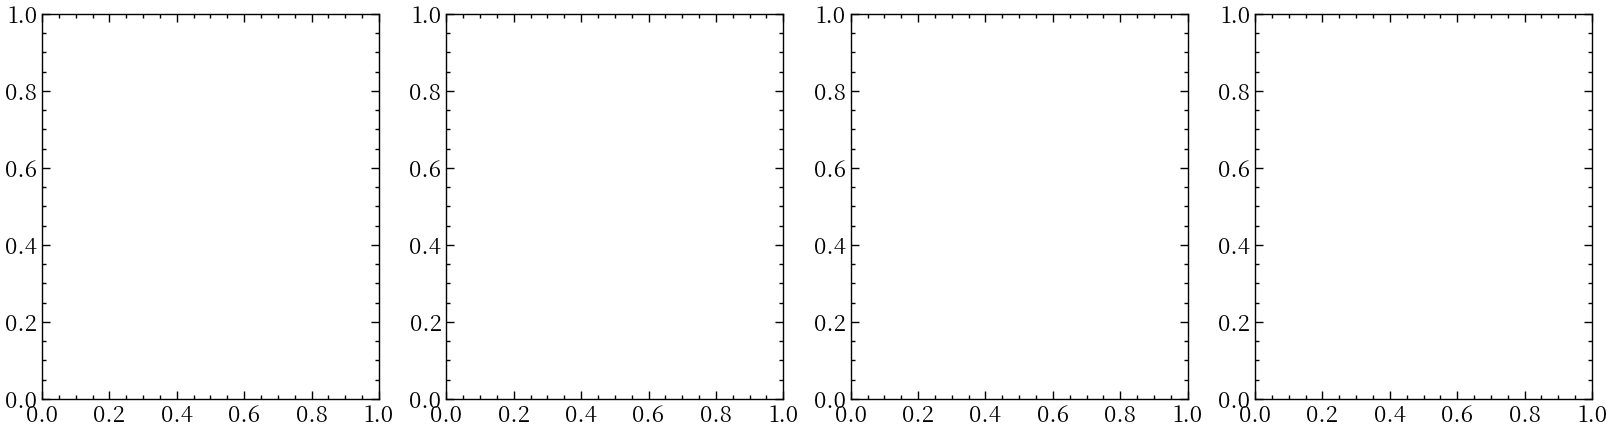

In [40]:
dpi=600
x = show_pred_imgs(pred_tup(underestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
# x.savefig("../../paper/assets/underpreds.png", dpi=dpi)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiyanschneider/Dropbox/scraper/imgs/full/a72688ade21416c500698b4dc16dbdff1504d7a5.jpg'

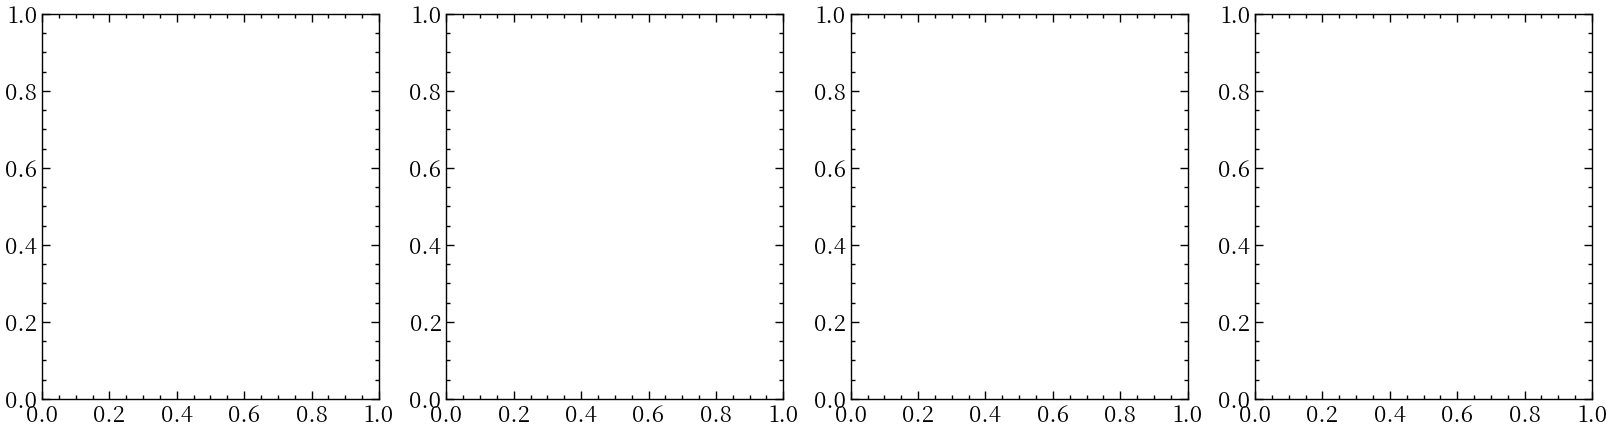

In [41]:
x = show_pred_imgs(pred_tup(overestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
# x.savefig("../../paper/assets/overpreds.png", dpi=dpi)

In [42]:
df.columns

Index(['b_name', 'b_age', 'b_address', 'b_no_floors', 'apt_detail_link',
       'apt_size', 'apt_rent', 'apt_style', 'apt_admin_price', 'apt_floor',
       'apt_thanks_fee', 'apt_deposit', 'full_apt_detail_link',
       'rel_image_paths', 'id', 'station', 'method', 'time_to_station', 'unit',
       'log_apt_rent', 'valid', 'viz_preds', 'viz_targs', 'time_to_station_sq',
       'mod1preds', 'mod2preds', 'exp_mod1preds', 'exp_mod2preds',
       'exp_viz_preds', 'exp_viz_targs'],
      dtype='object')

In [43]:
df.loc[underestimates]["full_apt_detail_link"]

134559    https://suumo.jp//chintai/jnc_000068226664/?bc=100250030144
139762    https://suumo.jp//chintai/jnc_000062637167/?bc=100228775706
83991     https://suumo.jp//chintai/jnc_000066460047/?bc=100240005078
124271    https://suumo.jp//chintai/jnc_000069920973/?bc=100259296710
50935     https://suumo.jp//chintai/jnc_000070343603/?bc=100261692386
Name: full_apt_detail_link, dtype: object

In [44]:
df["exp_viz_targs"].max()

250.00002053443936

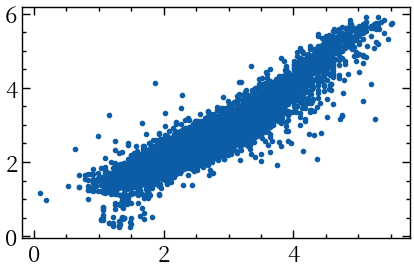

In [45]:
plt.scatter(df["viz_targs"], df["viz_preds"])

In [46]:
df["valid"]

0          True
1         False
2         False
3         False
4         False
          ...  
141389    False
141390    False
141391     True
141392     True
141393    False
Name: valid, Length: 141394, dtype: bool

In [47]:
((df[df["valid"]]["viz_preds"] - df[df["valid"]]["viz_targs"])**2).mean()

0.03420798895859065

# Summary stats

In [48]:
df["exp_viz_preds"].sort_values()[-15:]

/tmp/ipykernel_14188/1301751600.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df["exp_viz_preds"].sort_values()[-15:]


44082     303.219662
118430    303.324746
28690     305.218038
120578    307.486443
92205     309.147033
118432    310.821565
61047     310.871922
3027      316.518408
3026      319.548800
9285      323.587158
118301    324.279565
122110    337.571385
83112     342.103253
9283      364.410034
9284      364.410034
Name: exp_viz_preds, dtype: float64

In [49]:
cont = ["b_age", "b_no_floors", "apt_size", "apt_rent", "apt_admin_price", "apt_floor", "time_to_station"]
df[cont].describe().T

,count,mean,std,min,25%,50%,75%,max
b_age,141394.0,17.701062,15.081147,0.00,4.00,15.0,30.0,99.00
b_no_floors,141394.0,7.300168,5.734189,1.00,3.00,6.0,10.0,60.00
apt_size,141394.0,30.497512,17.251406,1.94,21.16,25.6,35.0,491.88
apt_rent,141394.0,11.119562,8.232117,1.10,7.50,9.1,12.1,250.00
apt_admin_price,141394.0,6554.481350,5220.711042,0.00,3000.00,6000.0,10000.0,220600.00
apt_floor,141394.0,4.096327,3.610408,1.00,2.00,3.0,5.0,57.00
time_to_station,141394.0,6.034167,3.284996,1.00,4.00,5.0,8.0,40.00


In [50]:
df.describe(include="category").T#.to_latex())

,count,unique,top,freq
apt_style,141394,31,1K,63573
station,141394,684,東京メトロ東西線/葛西駅,1839
method,141394,3,歩,140329


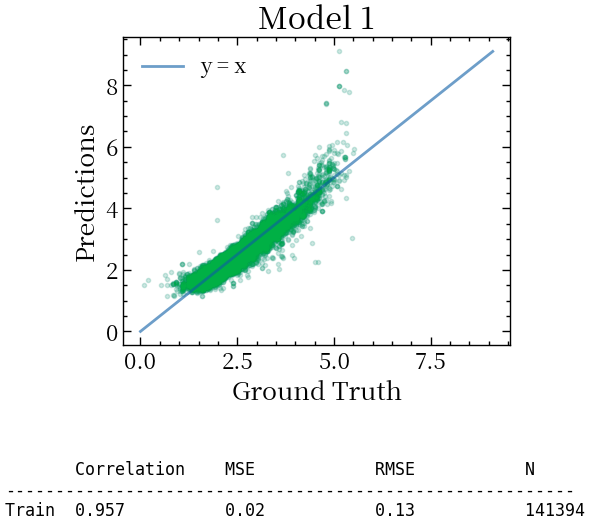

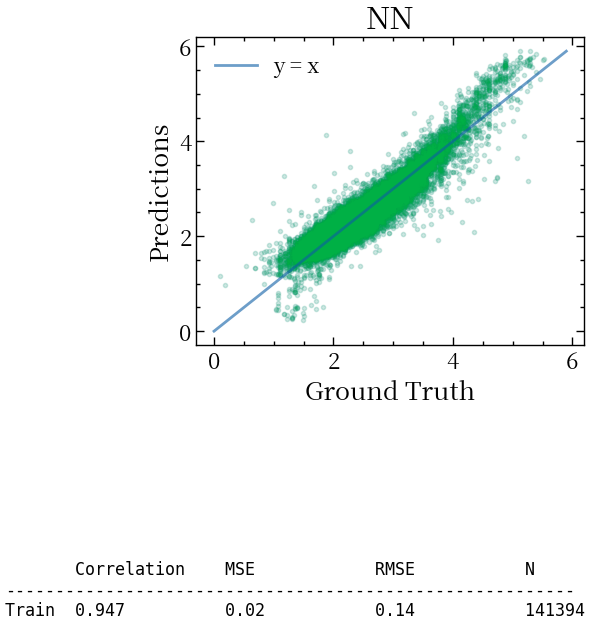

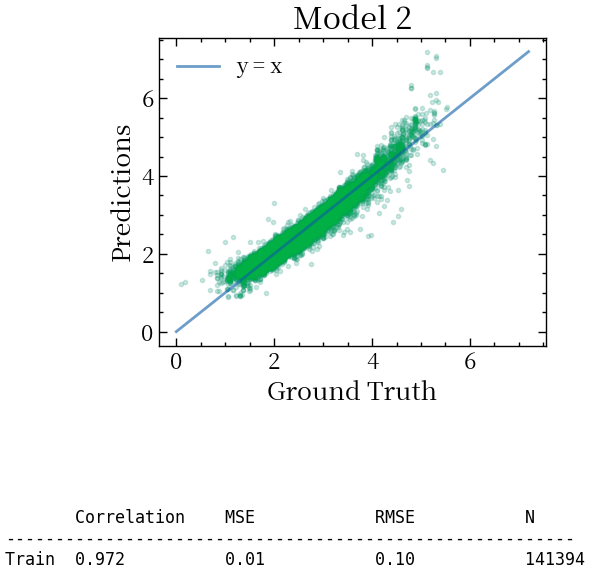

In [51]:
p1, s = plot_regression_once(df["mod1preds"], df["viz_targs"], model_name="Model 1")
pnn, s = plot_regression_once(df["viz_preds"], df["viz_targs"], model_name="NN")
p2, s = plot_regression_once(df["mod2preds"], df["viz_targs"], model_name="Model 2")

In [52]:
from collections import namedtuple
Stats = namedtuple("Stats", ["corr", "mse", "rmse", "N"])

def plot_model_summary(preds, targs, model_name, ax):
    targs = pd.Series(targs).reset_index(drop=True)
    preds - pd.Series(preds).reset_index(drop=True)
    m_se = mean_squared_error(preds, targs)
    trainstats = Stats(
        mse=m_se,
        rmse=np.sqrt(m_se),
        N=preds.shape[0],
        corr=preds.corr(targs),
    )
    ax.scatter(x=targs, y=preds, alpha=0.10)
    ax.scatter(x=targs, y=preds, alpha=0.10)
    m = max(targs.max(), preds.max())
    ax.plot([0, 8], [0, 8], label="y = x", alpha=0.6)
    ax.set_xlim((0, 8))
    ax.set_ylim((0, 8))
    ax.set_xlabel("Actual")
    ax.axvline(np.log(100), linestyle="dotted")
    # ax.legend(fontsize=15)
    # ax.ylabel("Predictions", fontsize=18)
    # ax.xlabel("Ground Truth", fontsize=18)
    ax.set_title(f"{model_name}", fontsize=22)
    return ax

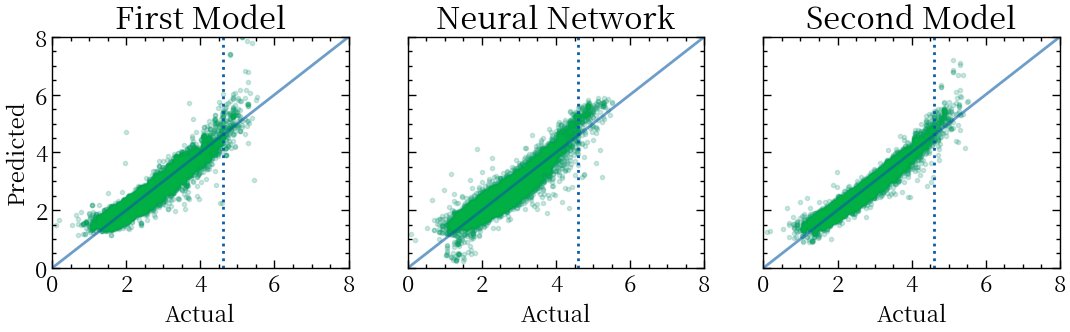

In [55]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 3) )
plot_model_summary(df["mod1preds"], df["viz_targs"], "First Model", axs[0])
plot_model_summary(df["viz_preds"], df["viz_targs"], "Neural Network", axs[1])
plot_model_summary(df["mod2preds"], df["viz_targs"], "Second Model", axs[2])
axs[0].set_ylabel("Predicted")
plt.savefig("../../paper/assets/residual_plot.png", dpi=dpi)

# axs[0].scatter(df["viz_preds"], df["viz_targs"])

In [56]:
similars = df[df[["apt_size", "station", "apt_style", "apt_admin_price", "apt_floor"]].duplicated()]

# Test Train split 

In [57]:
vdf = df[df["valid"]]

In [58]:
vdf.columns

Index(['b_name', 'b_age', 'b_address', 'b_no_floors', 'apt_detail_link',
       'apt_size', 'apt_rent', 'apt_style', 'apt_admin_price', 'apt_floor',
       'apt_thanks_fee', 'apt_deposit', 'full_apt_detail_link',
       'rel_image_paths', 'id', 'station', 'method', 'time_to_station', 'unit',
       'log_apt_rent', 'valid', 'viz_preds', 'viz_targs', 'time_to_station_sq',
       'mod1preds', 'mod2preds', 'exp_mod1preds', 'exp_mod2preds',
       'exp_viz_preds', 'exp_viz_targs'],
      dtype='object')

In [59]:
statistical = (vdf["apt_rent"]-vdf["exp_mod1preds"]).abs().sum()*10_000

In [60]:
ML = (vdf["apt_rent"]-vdf["exp_mod2preds"]).abs().sum()*10_000

In [61]:
print("Change in error (Yen): ", (statistical-ML)/statistical)

Change in error (Yen):  0.2666335110325589


In [64]:
print("Mean absolute error baseline: ",
      (vdf["apt_rent"] - vdf["exp_mod1preds"]).abs().mean()*10_000 )

Mean absolute error baseline:  15493.981408197653


In [65]:
print("Mean absolute error ML: ",
      (vdf["apt_rent"] - vdf["exp_mod2preds"]).abs().mean()*10_000)

Mean absolute error ML:  11362.76674545672


In [66]:
(15493 - 11362)/15493

0.26663654553669397

In [67]:
r2_score(vdf["apt_rent"], vdf["exp_mod2preds"])

-0.23018070518271405